# Inference

In [1]:
import os
import json
import torch
import argparse

from model_bowloss import SentenceVAE
from utils import to_var, idx2word, interpolate, AttributeDict

In [2]:
args = {
    'load_checkpoint': './bin/2019-Nov-29-05:41:12/E9.pytorch',
    'num_samples': 10,
    'data_dir': './data/eccos',
    'max_sequence_length': 50,
    'embedding_size': 300,
    'rnn_type': 'gru',
    'hidden_size': 256,
    'word_dropout': 0,
    'embedding_dropout': 0.5,
    'latent_size': 16,
    'num_layers': 1,
    'bidirectional': False
}
args = AttributeDict(args)
args.rnn_type = args.rnn_type.lower()
assert args.rnn_type in ['rnn', 'lstm', 'gru']
assert 0 <= args.word_dropout <= 1

## utils

In [7]:
def to_tensor(arr_like, cuda=True):
    tensor = torch.Tensor(arr_like)
    return tensor if not cuda else tensor.cuda()

## load vocab

In [8]:
with open('./data/eccos/src/ptb.vocab.json', 'r') as file:
        src_vocab = json.load(file)
src_w2i, src_i2w = src_vocab['w2i'], src_vocab['i2w']

## load model

In [4]:
model = SentenceVAE(
    vocab_size=len(w2i),
    sos_idx=w2i['<sos>'],
    eos_idx=w2i['<eos>'],
    pad_idx=w2i['<pad>'],
    unk_idx=w2i['<unk>'],
    max_sequence_length=args.max_sequence_length,
    embedding_size=args.embedding_size,
    rnn_type=args.rnn_type,
    hidden_size=args.hidden_size,
    word_dropout=args.word_dropout,
    embedding_dropout=args.embedding_dropout,
    latent_size=args.latent_size,
    num_layers=args.num_layers,
    bidirectional=args.bidirectional
    )

In [5]:
if not os.path.exists(args.load_checkpoint):
    raise FileNotFoundError(args.load_checkpoint)

model.load_state_dict(torch.load(args.load_checkpoint))
print("Model loaded from %s"%(args.load_checkpoint))

if torch.cuda.is_available():
    model = model.cuda()

Model loaded from ./bin/2019-Nov-19-20:12:46/E9.pytorch


In [6]:
model.eval()

SentenceVAE(
  (embedding): Embedding(12037, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (encoder_rnn): GRU(300, 256, batch_first=True)
  (decoder_rnn): GRU(300, 256, batch_first=True)
  (hidden2mean): Linear(in_features=256, out_features=16, bias=True)
  (hidden2logv): Linear(in_features=256, out_features=16, bias=True)
  (latent2hidden): Linear(in_features=16, out_features=256, bias=True)
  (outputs2vocab): Linear(in_features=256, out_features=12037, bias=True)
)

## random sampling inference

In [19]:
args.num_samples = 10

In [42]:
# ランダムサンプリング 推論
samples, z = model.inference(n=args.num_samples)
print('----------SAMPLES----------')
print(*[s.replace('<eos>', '') for s in idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])], sep='\n')

----------SAMPLES----------
ついつい やっ て いる ! 夏場 から 始める べき こと は 危険 だっ た ! 
<person> が お手本 で ♡ 「 <unk> 」 で 作る の は 
髪 を 切っ て いる けど 、 なんだか ケバ に は 難しい 。 そんな 時 に は 、 <unk> に 挑戦 し て み て 。 
「 イッセイ ミヤケ の 中性脂肪 が 溜まっ た 」 って 一体 どんな ? 
<unk> <num> ° c は おしゃれ な <person> ♡ <num> 円 台 で 買える 「 <unk> 」 
\ \ \ 今日 も 、 <num> 分 / 耐え なきゃ 損 ! 】 <num> 時間 が <num> 日 分 の <num> つ の ステップ が 気 に なる 方 に ! 
【 <num> 円 以下 】 で 可愛く なり たい ! おすすめ の ネイルサロン 
これ は 優秀 ♡ 美容 大国 「 <unk> 」 が 超 優秀 ! 
いまさら 聞け ない ! 美人 度 が 高まる ` ` 精製水 " は ナチュラル な 眉 脱色 
長時間 持続 ! 長時間 持続 する 薬用 美白 美容液 


In [61]:
# ｚをずらしていく系サンプリング 推論
print('-------INTERPOLATION-------')
z1 = torch.randn([args.latent_size]).numpy()
z2 = torch.randn([args.latent_size]).numpy()
z = to_var(torch.from_numpy(interpolate(start=z1, end=z2, steps=8)).float())
samples, _ = model.inference(z=z)
print(*[s.replace('<eos>', '').replace(' ', '') for s in idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])], sep='\n')

-------INTERPOLATION-------
「<unk>」との違いとは?
「<unk>」との違いとは?
「<unk>」との違いとは?
「<unk>」との違いとは?
「<unk>」との違いとは?
「<unk>」との違いとは?
「それはどこの?」と聞かれるような肌になるかも。
「それはどこの?」と聞かれるほどの嵐。
「人類と違う」って言われた?実はかえって逆効果なの?
「人類と違う」って言われた?実はかえって逆効果な唇の作り方をマスターしてみて。


## sample 指定 inference

### load test data

In [53]:
from ptb import PTB
test_ptb = PTB(
    data_dir='./data/eccos',
    split='test',
    create_data=False,
)

In [54]:
test_ptb

In [57]:
# 実際のデータ確認用
def ids2text(id_list, ptb):
    return ''.join([ptb.i2w[f'{i}'] for i in id_list])

In [90]:
# データをピックアップ, 確認
sample = test_ptb.data['132']
print(f'▼ Input length:{sample["length"]}\n{ids2text(sample["input"], test_ptb)}')
sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)

▼ Input length:21
<sos><unk>とした疲れ顔とおさらば!仕事を頑張る現代女子には「血色メイク」<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


### sampling

In [91]:
# 潜在変数zの取得
logp, mean, logv, z = model.forward(sample_input, sample_length)
samples, _ = model.inference(z=z)
print('■ 入力')
print(*idx2word(torch.Tensor(sample['input']).int().view(1, -1), i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')
print('■ サンプリング')
print(*[s.replace('<eos>', '').replace(' ', '') for s in idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])], sep='\n')

■ 入力
<sos> <unk> と し た 疲れ 顔 と おさらば ! 仕事 を 頑張る 現代 女子 に は 「 血色 メイク 」
■ サンプリング
肌悩みは「七難」で改善している人には?


In [92]:
# n回サンプリング
args.num_samples = 30
n_samples = [model.forward(sample_input, sample_length) for _ in range(args.num_samples)]
z = torch.cat([z for logp, mean, logv, z in n_samples])
samples, _ = model.inference(z=z)
print('■ 入力')
print(*idx2word(torch.Tensor(sample['input']).int().view(1, -1), i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')
print('■ サンプリング')
print(*[s.replace('<eos>', '').replace(' ', '') for s in idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])], sep='\n')

■ 入力
<sos> <unk> と し た 疲れ 顔 と おさらば ! 仕事 を 頑張る 現代 女子 に は 「 血色 メイク 」
■ サンプリング
「毛穴レス肌がきれいに見える」と言われたい人のリキッドファンデを握る
「<unk>」は挫けに向けてみない?古来や<unk>など、<unk>を<unk>ても<unk>を<unk>う♡
「ザラつき」がキモ!熱中症を改善する方法とは
「<unk>」とは?
美肌には「すっぴん風」に!全身にも使える万能コスメ<num>選
「<num>歳は<unk>」を作るかも?ギャップ萌えを駆使して、いつもと違う雰囲気を手に入れて♡
<unk>とした時は、肌に優しい!「<unk>」の原因とは
「あー肌は見違える!」としたアクアレーベルを実感した美容液。
「<unk>」とは?その答えを改善する方法とは?
<unk>はハタチにしている!<unk>とは違う「<unk>」の原因とは
<unk>とした時は、肌を美しくする。<num>つの習慣で、肌を美しく見せるために、<unk>を美しく
「<unk>」とは?若い肌をつくる方法とは?
歯をキレイに♡「セラミッククラウン」とは?
<unk>とは違う!「<unk>」で作られた印象のように、手の甲を美しく魅せる方法を紹介します。
<unk>はハタチには<unk>を<unk>てもいいじゃないとした。怒らない<unk>を<unk>て、<unk>を確保してみて。
「<unk>」とは言われた!そんな時は、<unk>を確保する方法を教えます。
「<unk>」とは?若いうちにも悪影響を及ぼす!
「今日は<unk>」と挫けていた。そんな時は、いつもと違う私になるかも?
<unk>には<unk>が無い!寝る前にやるべきのは「セラミッククラウン」とは
<unk>はハタチ!原因とは違う原因を心得て、寝る前にやるべきことを。
美人度は歯になるかも。「セラミッククラウン」とは?
ナチュラルなツヤ肌になれる♡「<unk>」とは?
美人は女性になりたい人から卒業している「<unk>」とは?
<unk>を<unk>とした時は、<unk>に<unk>!<unk>を上げる方法を教えます♡
「<unk>」は挫けな肌に!``<unk>"をつくる習慣とは
「<unk>」とは?<unk>にも悪影響を及ぼす!
「<unk>」とは?「あなただけを見つめる」

## 潜在空間のプロット
圧縮して分布を確認してみる

In [24]:
import umap.umap_ as umap

In [32]:
# 描画用
# https://github.com/lmcinnes/umap/blob/master/notebooks/UMAP%20usage%20and%20parameters.ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})
def plot_scatter(u, title=''):
    fig = plt.figure()
    n_components = u.shape[1]
    plot_kwargs = {'alpha': 0.5, 's':5}
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), **plot_kwargs)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], **plot_kwargs)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d', **plot_kwargs)
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

### load test data

In [7]:
from ptb import PTB
test_ptb = PTB(
    data_dir='./data/eccos',
    split='test',
    create_data=False,
)

In [8]:
def sample_to_tensor(sample):
    sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
    sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)
    return sample_input, sample_length

In [22]:
%%time
# テストデータを潜在変数に変換
with torch.no_grad():
    encoded_samples = [model.encode(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
    encoded_mean_list = [mean.tolist() for mean, std, z in encoded_samples]

CPU times: user 15.4 s, sys: 983 ms, total: 16.4 s
Wall time: 16.4 s


In [26]:
encoded_mean_arr = np.array(encoded_mean_list)

In [27]:
encoded_mean_arr.shape

(9603, 16)

In [ ]:
%%time
mean_u = umap.UMAP().fit_transform(encoded_mean_arr)

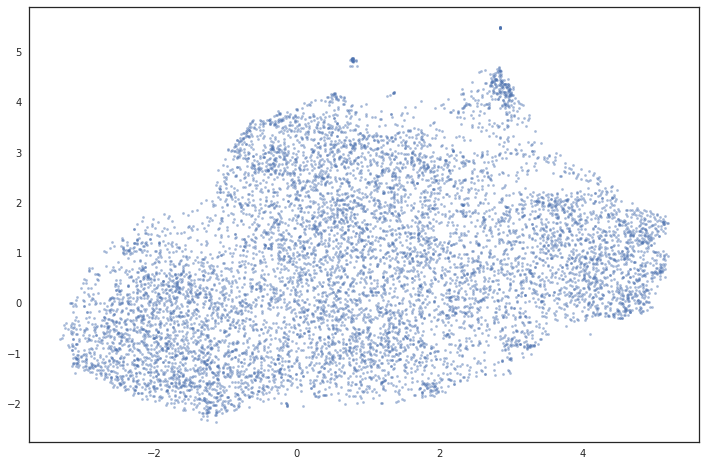

In [33]:
plot_scatter(mean_u)

- 分布の形の歪さは、umapの特性によるものなので、なんとも言えない
- ただ、分布の中で偏りはある程度あるので、この偏りの箇所を確認したい
- また、近しい箇所や遠い箇所で意味的な距離がありそうかを確かめたい